# Braille Alphabate

In [180]:
import cv2
import numpy as np
from scipy.cluster.hierarchy import fclusterdata
import matplotlib.pyplot as plt

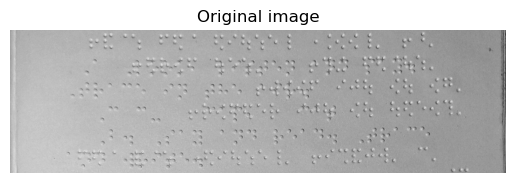

In [181]:
image = cv2.imread("b9.jpg", cv2.IMREAD_GRAYSCALE)

output_image = image.copy()
output_image2 = image.copy()

h,w = image.shape

if w > 500:
    new_w = 500
    ar = w/h
    new_h = int(new_w/ar)

    img = cv2.resize(image,(new_w,new_h),interpolation=cv2.INTER_AREA)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Original image")
plt.axis('off')
plt.show()

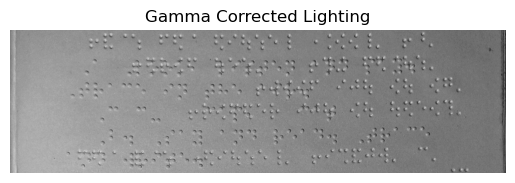

In [182]:
#gama correction 
def gamma_correction(image, gamma=2.5):
    normalized = image / 255.0
    corrected = np.power(normalized, gamma)
    
    return (corrected * 255).astype(np.uint8)

corrected_image = gamma_correction(image, gamma=3)

plt.imshow(corrected_image, cmap='gray')
plt.axis('off')
plt.title("Gamma Corrected Lighting")
plt.show()


In [183]:
def dilation(image, kernel_size=(3, 3), iterations=1):
    
    kernel = np.ones(kernel_size, np.uint8)
    dilated_image = cv2.dilate(image, kernel, iterations=iterations)
    dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, kernel)   
    return dilated_image

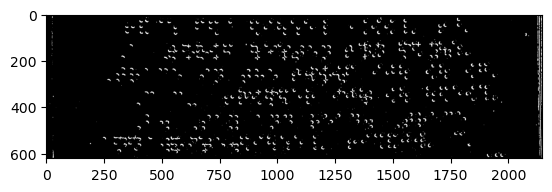

In [184]:
def thresholding(image):
    blur = cv2.GaussianBlur(image, (7, 7), 0)
    thresh = cv2.adaptiveThreshold(
        blur,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        3
    )
    return thresh
thresh_img = thresholding(corrected_image);

plt.imshow(thresh_img, cmap='gray')
plt.show()

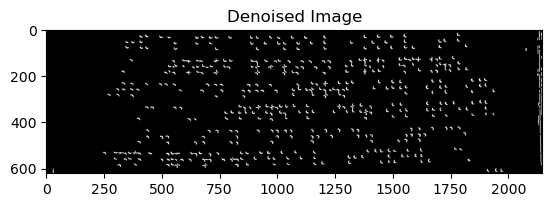

In [185]:
def remove_noise(image, kernel_size=3, min_size=50):

    # Morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    denoised = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    # remove small regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(denoised, connectivity=8)
    output = np.zeros_like(denoised)

    for i in range(1, num_labels):  # Skip the background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255

    return output

# Example Usage
denoised_image = remove_noise(thresh_img, kernel_size=3, min_size=30)

# Display the results
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.show()


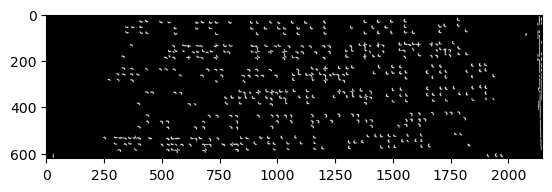

In [186]:
def sharping(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    sharp = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

    return sharp
sharp_image=sharping(denoised_image)
# Display the result
plt.imshow(sharp_image,cmap='gray')

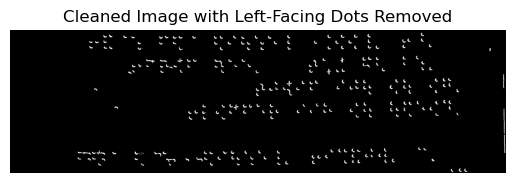

In [187]:
def remove_left_facing_dots(image, intensity_ratio_threshold=1.2):

    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        roi = image[y:y+h, x:x+w]
        left_half = roi[:, :w//2].sum()
        right_half = roi[:, w//2:].sum()

        if right_half < left_half * intensity_ratio_threshold:
            filtered_contours.append(contour)

    
    mask = np.zeros_like(image)
    cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

    cleaned_image = cv2.bitwise_and(image, mask)

    return cleaned_image


cleaned_image = remove_left_facing_dots(sharp_image, intensity_ratio_threshold=1.3)

plt.imshow(cleaned_image, cmap='gray')
plt.title("Cleaned Image with Left-Facing Dots Removed")
plt.axis('off')
plt.show()

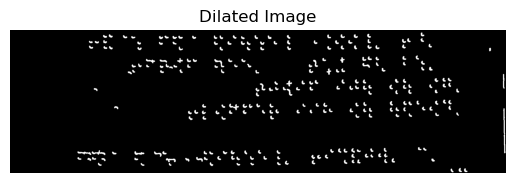

In [188]:
dilated_image = dilation(cleaned_image, kernel_size=(3, 3), iterations=1)

# Display the result
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Image')
plt.axis('off')
plt.show()


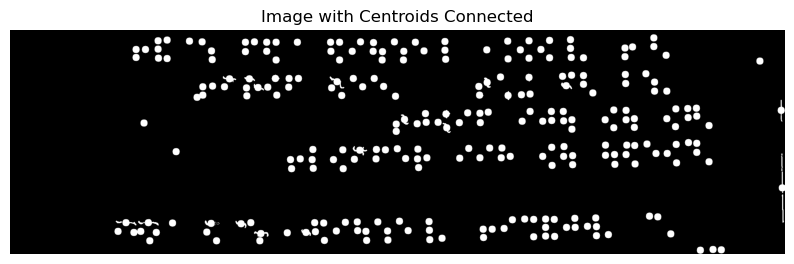

In [189]:
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))

# Add dots (circles) at each centroid and connect them with lines
for i, (cX, cY) in enumerate(centroids):
    # Draw circle at each centroid
    cv2.circle(output_image2, (cX, cY), 5, (0, 0, 255), -1) 
    cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)
    cv2.circle(cleaned_image,(cX,cY),10,(255,0,255),-1)
    

# Display the image with centroids marked and connected

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image with Centroids Connected")
plt.show()

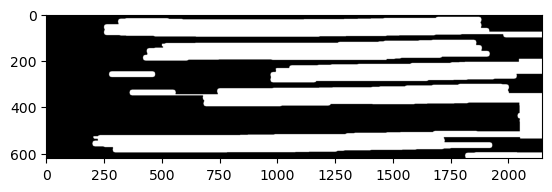

In [190]:
dilated =dilation(cleaned_image,(5,180),1)
plt.imshow(dilated,cmap='gray')

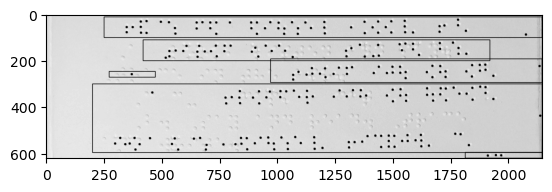

In [191]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)


img2 = output_image2.copy()
line_images = []


for ctr in sorted_contours_lines:
    
    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (0, 255, 0), 2)

     # Crop each line and store it in the line_images array
    line_image = img[y:y + h, x:x + w]
    line_images.append(line_image)
   
plt.imshow(img2,cmap='gray');

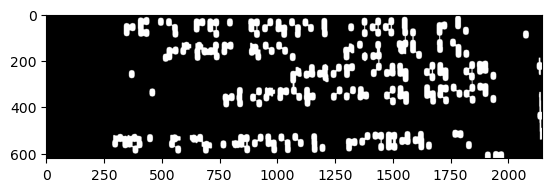

In [192]:
dilated2=dilation(cleaned_image,(15,5),1)
plt.imshow(dilated2,cmap='gray')

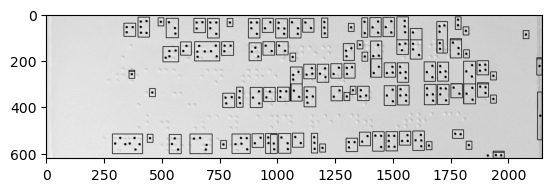

In [193]:
img3 = image.copy()
words_list = []

for line in sorted_contours_lines:
    
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 600:
           continue
        
        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (0,255,0),2)
        
plt.imshow(img3,cmap='gray');

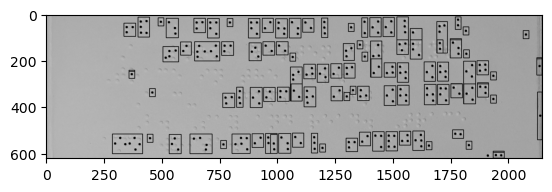

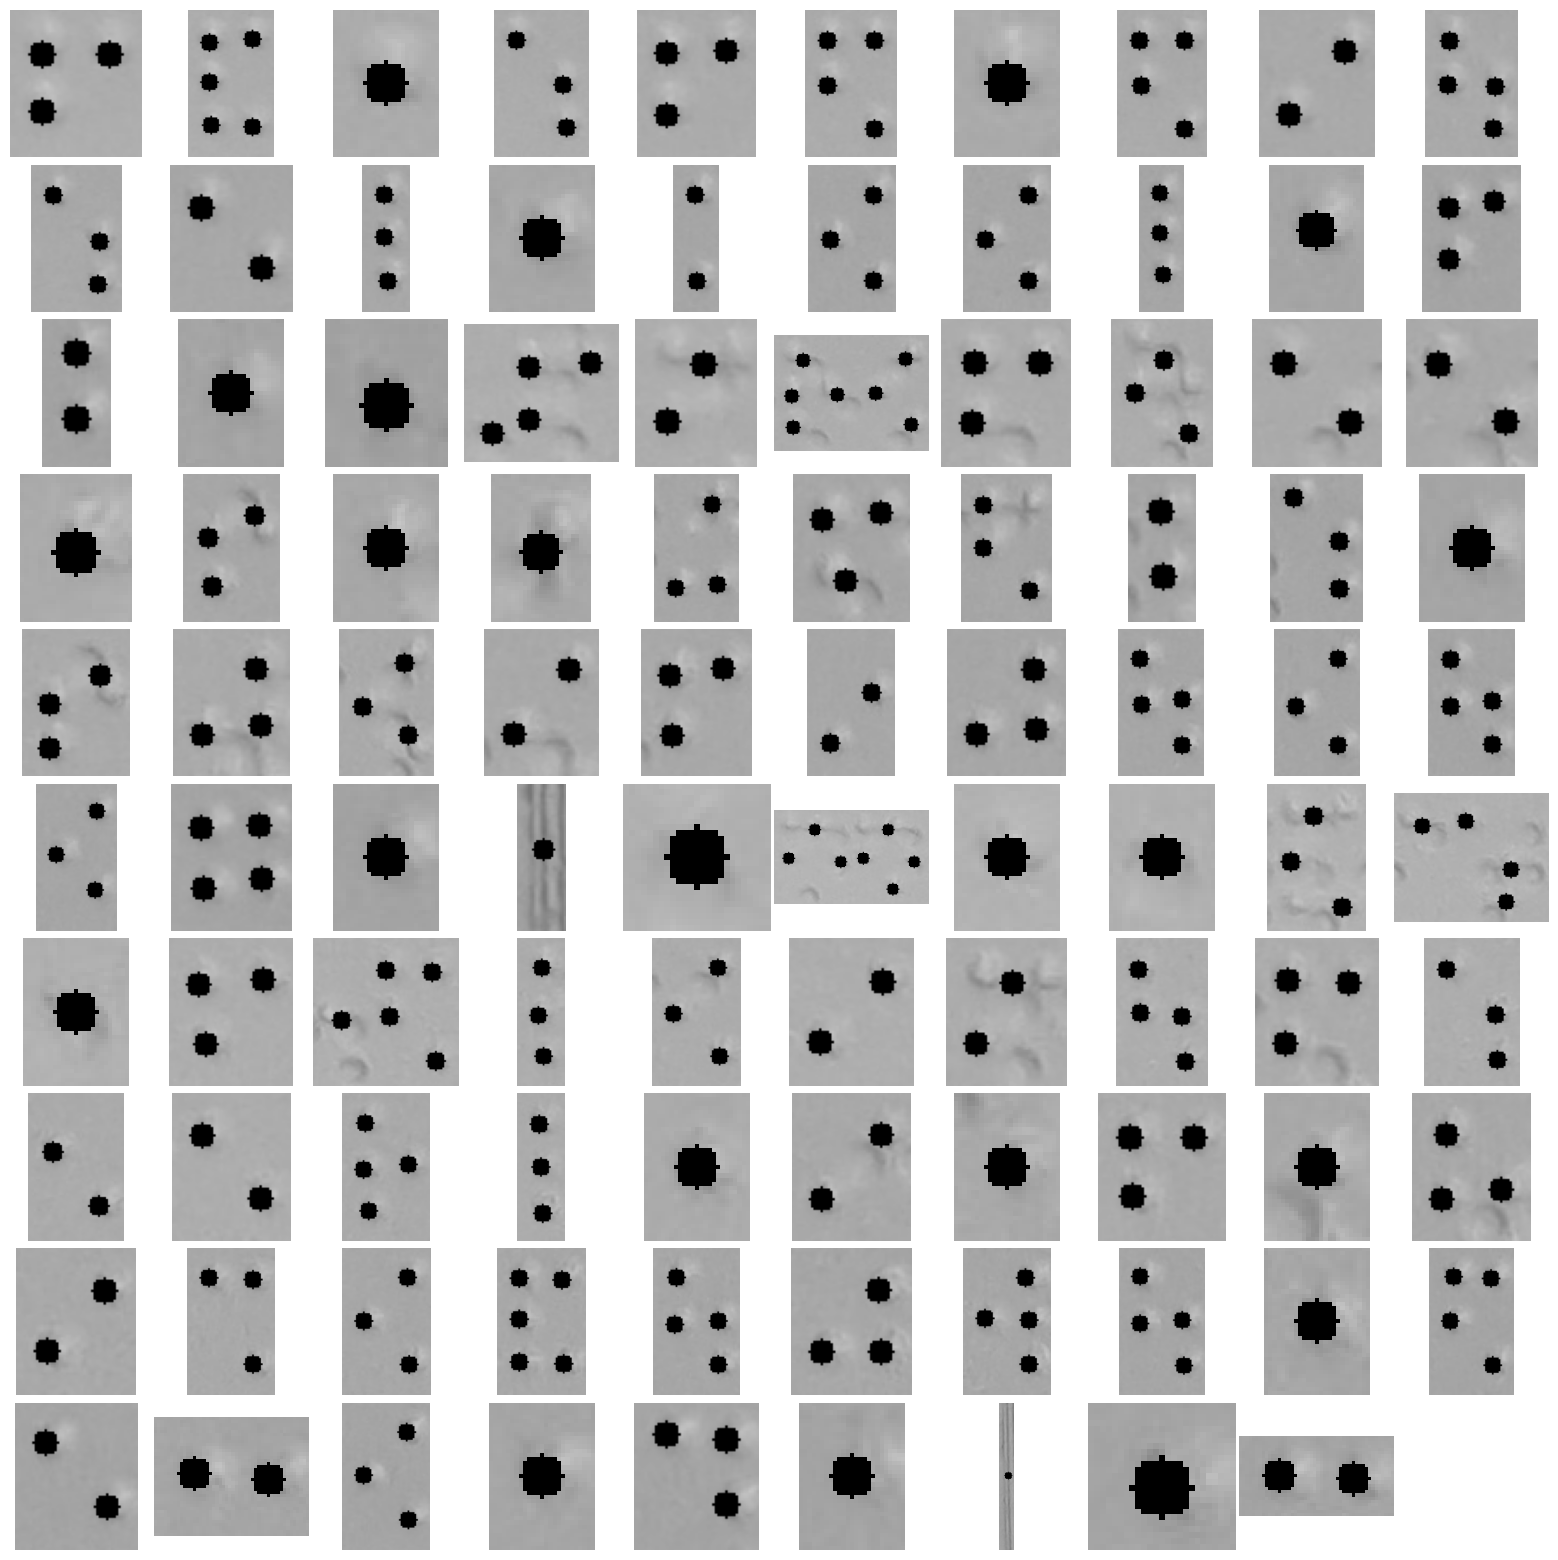

In [194]:
segments = []


# Iterate through the sorted contours (lines)
for line in sorted_contours_lines:
    
    # Get the bounding box for each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+h, x:x+w]  
    
    # Find the contours within the line ROI
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    # Iterate through each word contour
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 400:  # Ignore small contours (noise)
            continue
        
        # Get the bounding box for each word
        x2, y2, w2, h2 = cv2.boundingRect(word)
        
        # Add the word bounding box to the words list
        words_list.append([x + x2, y + y2, x + x2 + w2, y + y2 + h2])
        
        # Crop the word image from the original image and store it in 'segments'
        word_segment = image[y + y2:y + y2 + h2, x + x2:x + x2 + w2]
        segments.append(word_segment)
        
        

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()



# Calculate the number of segments and the number of rows/columns needed for the plot
num_segments = len(segments)
images_per_row = 10
num_rows = (num_segments // images_per_row) + (num_segments % images_per_row != 0)

# Create a figure with a size based on the number of segments
plt.figure(figsize=(2 * images_per_row, 2 * num_rows))

# Plot each segment (cropped word)
for i, segment in enumerate(segments):
    row = i // images_per_row
    col = i % images_per_row
    
    # Create a subplot for each word segment
    plt.subplots_adjust(hspace=0.05, wspace=0.005)
    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()


In [195]:
# import os
# import cv2
# import matplotlib.pyplot as plt

# # Define the directory where you want to save the segments
# output_folder = "segments_output"

# # Create the folder if it doesn't already exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Save each segment as an image
# for i, segment in enumerate(segments):
#     # Construct the file name
#     file_name = f"segment_{i + 1}.png"
#     file_path = os.path.join(output_folder, file_name)
    
#     # Save the segment image
#     cv2.imwrite(file_path, segment)

# print(f"All segments have been saved in the folder: {output_folder}")
